I donwloaded recent water level observations from this website.
http://www.pac.dfo-mpo.gc.ca/science/charts-cartes/obs-app/observed-eng.aspx?StationID=07795

For comparison with nowcast or forecast.

In [1]:
import pandas as pd
from dateutil import tz
import datetime
import numpy as np
import os
import netCDF4 as nc
import matplotlib.pyplot as plt

from nowcast import analyze, residuals
from nowcast.figures import shared, figures
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_color_codes()

In [3]:
def dateparse(s):
    """Function to make datetime object aware of time zone
    e.g. date_parser=dateParserMeasured('2014-05-31 11:42')

    :arg s: string of date and time
    :type s: str

    :returns: datetime object that is timezone aware
    """
    PST_tz = tz.tzoffset("PST", -28800)
    # Convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M")
    # Add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST_tz)
    # Convert to UTC
    return aware.astimezone(tz.tzutc())

In [4]:
data = pd.read_csv('PA_Nov2016.csv',parse_dates=[1],date_parser=dateparse)
data=data.rename(columns={'TIME_TAG PST (Z+8)': 'time'})
series = pd.Series(np.array(data['ENCODER2']), index = data['time'])
series=series.resample('15T')

In [5]:
nowcast = '/results/SalishSea/nowcast-blue/'
location = 'PointAtkinson'
tides_path = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/'
grid={}
sdt = datetime.datetime(2016,11,1)
edt = datetime.datetime(2016,11,30)

numdays = (edt-sdt).total_seconds()/86400
dates = [sdt + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

ssh = np.array([])
time = np.array([])
for d in dates:
    fname = os.path.join(nowcast, d.strftime('%d%b%y').lower(), '{}.nc'.format(location))
    grid = nc.Dataset(fname)
    s,t = figures.load_model_ssh(grid)
    ssh=np.append(ssh,s)
    time=np.append(time,t)
tides = shared.get_tides('Point Atkinson',path=tides_path)
ssh_corr = shared.correct_model_ssh(ssh, time,tides )

## compare water levels - observed, model, tides

In [6]:
series.values

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


array([ 1.586     ,  1.65693333,  1.74526667, ...,  1.15233333,
        1.04406667,  0.96278571])

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  from ipykernel import kernelapp as app


(736269.0, 736298.0)

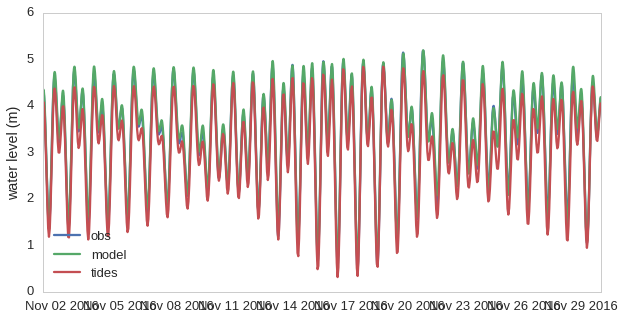

In [7]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(series.index, series.values, label='obs')
ax.plot(time,ssh_corr+figures.SITES['Point Atkinson']['msl'], label='model')
ax.plot(tides.time, tides.pred_all + figures.SITES['Point Atkinson']['msl'], label='tides')
ax.set_ylabel('water level (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt,edt])

This looks reasonable

## compare residuals - observed, modelled

In [8]:
obs_interp = shared.interp_to_model_time(time, series.values, series.index)
obs_interp = np.array(obs_interp) - figures.SITES['Point Atkinson']['msl']

model_res =residuals.compute_residual(ssh_corr, time, tides)
obs_res = residuals.compute_residual(obs_interp, time, tides)

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


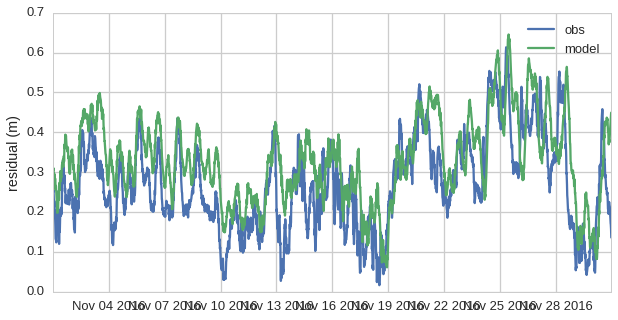

In [20]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(time, obs_res, label='obs')
ax.plot(time, model_res, label='model')
ax.set_ylabel('residual (m)')
ax.legend()

## Error

-0.0597936387957


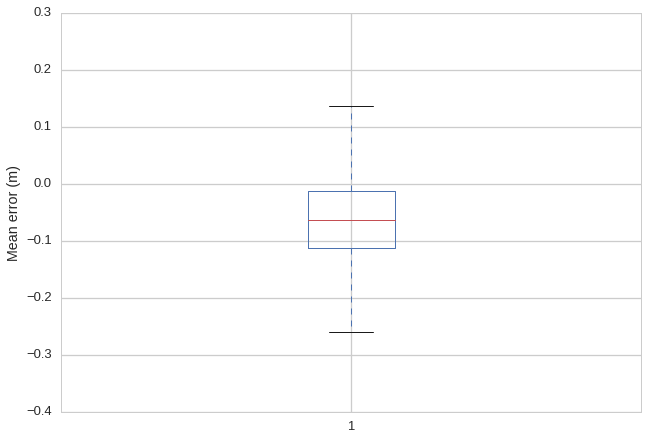

In [10]:
error_nowcast = obs_res - model_res
plt.boxplot(error_nowcast)
print(error_nowcast.mean())
plt.ylabel('Mean error (m)')

0.0825854507483


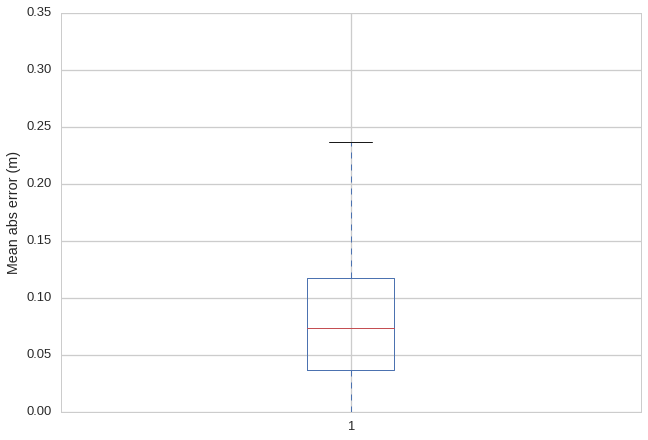

In [11]:
plt.boxplot(np.abs(error_nowcast))
print(np.abs(error_nowcast).mean())
plt.ylabel('Mean abs error (m)')



# Forecasts

In [12]:
nowcast = '/results/SalishSea/forecast/'
location = 'PointAtkinson'
grid={}
numdays = (edt-sdt).total_seconds()/86400
dates = [sdt + datetime.timedelta(days=d-1) for d in np.arange(numdays+1) ]

ssh_forecast = np.array([])
time_forecast = np.array([])
for d in dates:
    fname = os.path.join(nowcast, d.strftime('%d%b%y').lower(), '{}.nc'.format(location))
    grid = nc.Dataset(fname)
    s,t = figures.load_model_ssh(grid)
    s_sub = s[0:144] #subsample for just one day
    t_sub = t[0:144]
    ssh_forecast=np.append(ssh_forecast,s_sub)
    time_forecast=np.append(time_forecast,t_sub)
ssh_corr_forecast = shared.correct_model_ssh(ssh_forecast, time_forecast,tides )
model_res_forecast =residuals.compute_residual(ssh_corr_forecast, time_forecast, tides)

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  app.launch_new_instance()


[None, None, None, None, None, None, None, None, None, None]

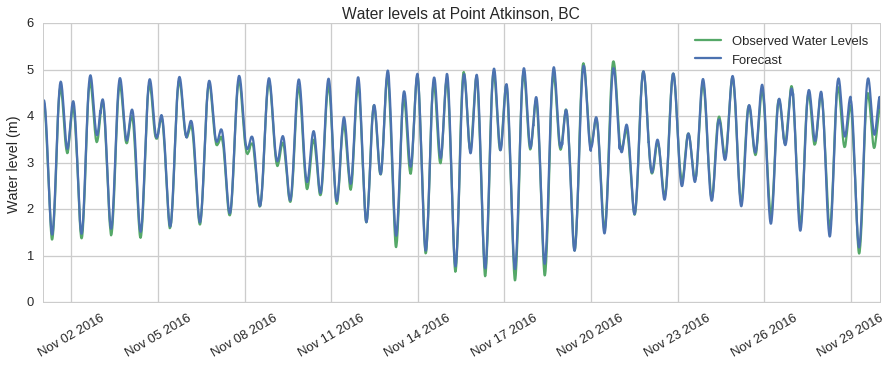

In [13]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
#ax.plot(time,ssh_corr+figures.SITES['Point Atkinson']['msl'], 'g--',label='Nowcast')
ax.plot(series.index, series.values, 'g',label='Observed Water Levels')
ax.plot(time_forecast,ssh_corr_forecast+figures.SITES['Point Atkinson']['msl'], 'b',label='Forecast')
ax.set_ylabel('Water level (m)')
ax.legend(loc=0)
ax.set_xlim([sdt,edt])
ax.set_title('Water levels at Point Atkinson, BC')
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)

Only first 24 hours of forecast

In [14]:
rs = '1H'
obs_series = pd.Series(obs_res,index=time)
obs_series=obs_series.resample(rs)
forecast_series = pd.Series(model_res_forecast, index = time_forecast)
forecast_series=forecast_series.resample(rs)
nowcast_series = pd.Series(model_res, index = time)
nowcast_series=nowcast_series.resample(rs)

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  from ipykernel import kernelapp as app
/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  app.launch_new_instance()
/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


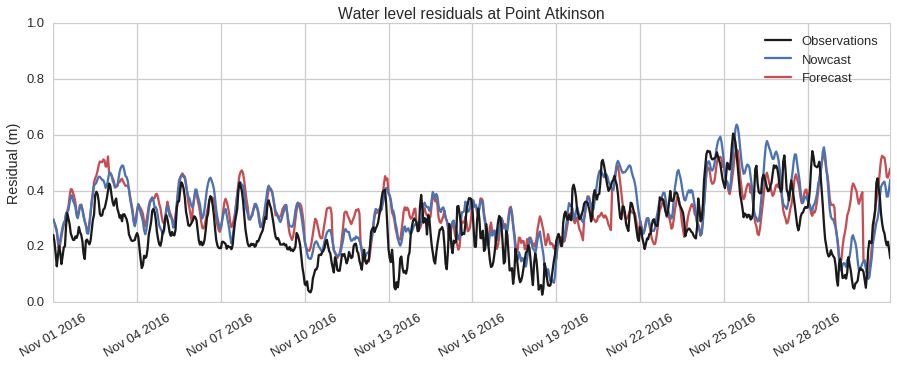

In [15]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(obs_series.index, obs_series.values, 'k', label='Observations',zorder=10)
ax.plot(nowcast_series.index, nowcast_series.values, 'b',label='Nowcast',zorder=9)
ax.plot(forecast_series.index, forecast_series.values,'r', label='Forecast')
ax.set_ylabel('Residual (m)')
ax.set_ylim([0,1])
ax.legend()
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)
ax.set_title('Water level residuals at Point Atkinson')

In [22]:
fig.savefig('/home/nsoontie/Desktop/Residuals_Nov2015.png',dpi=300,bbox_inches='tight')

In [16]:
time_forecast

array([datetime.datetime(2016, 11, 1, 0, 5, tzinfo=tzutc()),
       datetime.datetime(2016, 11, 1, 0, 15, tzinfo=tzutc()),
       datetime.datetime(2016, 11, 1, 0, 25, tzinfo=tzutc()), ...,
       datetime.datetime(2016, 11, 30, 23, 35, tzinfo=tzutc()),
       datetime.datetime(2016, 11, 30, 23, 45, tzinfo=tzutc()),
       datetime.datetime(2016, 11, 30, 23, 55, tzinfo=tzutc())], dtype=object)

In [17]:
forecast_error = obs_res-model_res_forecast

-0.0565552239318


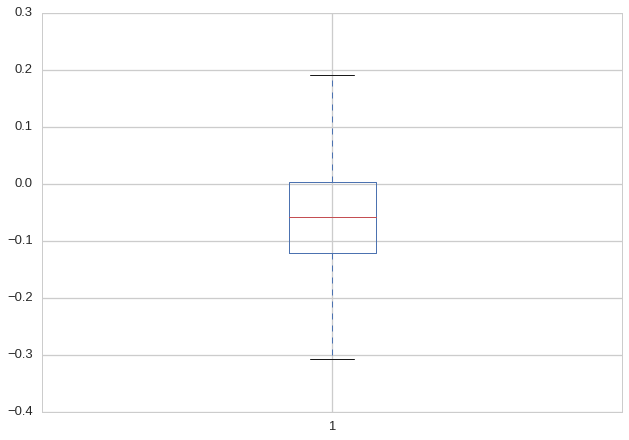

In [18]:
plt.boxplot(forecast_error)
print(forecast_error.mean())

0.0927861219049


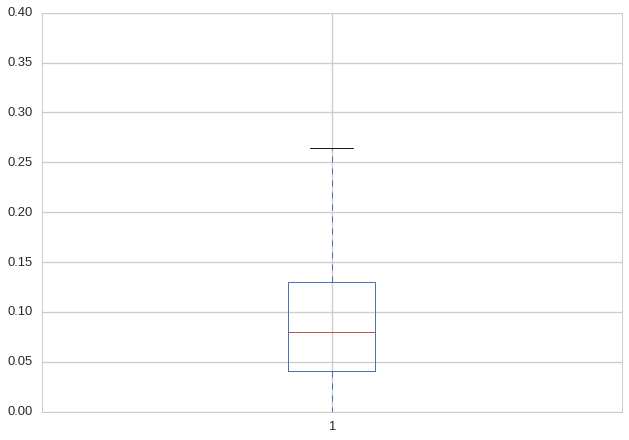

In [19]:
plt.boxplot(np.abs(forecast_error))
print(np.abs(forecast_error).mean())